In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings; warnings.filterwarnings('ignore')

In [8]:
#Loading dataset
booking = pd.read_csv('diabetes.csv')
df = booking[["Glucose", "BloodPressure", "Insulin", "DiabetesPedigreeFunction","Age","Outcome"]]

In [9]:
#Dataset info
df.shape

(768, 6)

In [10]:
df.describe()


,Glucose,BloodPressure,Insulin,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,120.894531,69.105469,79.799479,0.471876,33.240885,0.348958
std,31.972618,19.355807,115.244002,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,99.000000,62.000000,0.000000,0.243750,24.000000,0.000000
50%,117.000000,72.000000,30.500000,0.372500,29.000000,0.000000
75%,140.250000,80.000000,127.250000,0.626250,41.000000,1.000000
max,199.000000,122.000000,846.000000,2.420000,81.000000,1.000000


In [11]:
#Extracting and analysing through isolation forest
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['is_inlier_IF'] = iso_forest.fit_predict(df)

In [12]:
inliers_IF = df[df['is_inlier_IF'] == 1]
outliers_IF = df[df['is_inlier_IF'] == -1]

In [13]:
outliers_IF

,Glucose,BloodPressure,Insulin,DiabetesPedigreeFunction,Age,Outcome,is_inlier_IF
4,137,40,168,2.288,33,1,-1
8,197,70,543,0.158,53,1,-1
12,139,80,0,1.441,57,0,-1
13,189,60,846,0.398,59,1,-1
15,100,0,0,0.484,32,1,-1
...,...,...,...,...,...,...,...
662,167,106,231,0.165,43,1,-1
695,142,90,480,0.128,43,1,-1
715,187,50,392,0.826,34,1,-1
753,181,88,510,0.222,26,1,-1


In [14]:
inliers_IF

,Glucose,BloodPressure,Insulin,DiabetesPedigreeFunction,Age,Outcome,is_inlier_IF
0,148,72,0,0.627,50,1,1
1,85,66,0,0.351,31,0,1
2,183,64,0,0.672,32,1,1
3,89,66,94,0.167,21,0,1
5,116,74,0,0.201,30,0,1
...,...,...,...,...,...,...,...
763,101,76,180,0.171,63,0,1
764,122,70,0,0.340,27,0,1
765,121,72,112,0.245,30,0,1
766,126,60,0,0.349,47,1,1


In [15]:
def is_inlier(row):
    # Glucose constraint: 0 < Glucose < 200
    if row['Glucose'] < 0 or row['Glucose'] > 200:
        return -1

    # Insulin constraint: 0 < Insulin < 900
    if row['Insulin'] < 0 or row['Insulin'] > 900:
        return -1

    #Blood pressure constraint: should be < 180 
    if row['BloodPressure'] > 180:
        return -1
        
    #DiabetesPedigreeFunction constraint: cant be > 2.5
    if row['DiabetesPedigreeFunction'] > 2.5:
        return -1
        
    #DiabetesPedigreeFunction constraint: If age >60, DiabetesPedigreeFunction < 2
    if row['Age'] > 60 and row['DiabetesPedigreeFunction'] > 2:
        return -1
        
    #Outcome constraint: should be either 1 or 0
    if row['Outcome'] not in [0, 1]:
        return -1

    # If all constraints are satisfied, return True
    return 1

In [16]:
#Extracting and analysing through human-written constraints
df['is_inlier_HW'] = df.apply(is_inlier, axis=1)

In [17]:
inliers_HW = df[df['is_inlier_HW'] == 1]
outliers_HW = df[df['is_inlier_HW'] == -1]
outliers_HW

,Glucose,BloodPressure,Insulin,DiabetesPedigreeFunction,Age,Outcome,is_inlier_IF,is_inlier_HW


In [18]:
#disagreements between two methods
df['similar'] = abs(df['is_inlier_IF'] + df['is_inlier_HW']) / 2

In [19]:
mismatch = df[df['similar'] == 0]
similar = df[df['similar'] == 1]

In [20]:
#writing the disagreed datapoints into csv
mismatch.to_csv("disagreement.csv")

In [21]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

conf_matrix = confusion_matrix(df['is_inlier_HW'], df['is_inlier_IF'])
conf_matrix

array([[  0,   0],
       [ 77, 691]])

Text(95.72222222222221, 0.5, 'Handwritten')

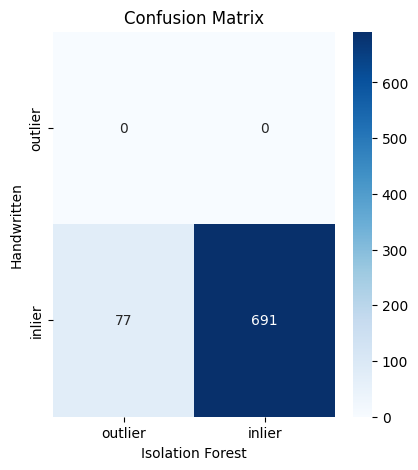

In [22]:
# Plot confusion matrix
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["outlier","inlier"], yticklabels=["outlier","inlier"])
plt.title("Confusion Matrix")
plt.xlabel("Isolation Forest")
plt.ylabel("Handwritten")

In [23]:
#Both agree it is inlier
all_inlier = df[(df['is_inlier_IF'] == 1) & (df['is_inlier_HW'] == 1)] 
all_inlier.to_csv("all_inlier.csv")

In [24]:
#Both agree it is outlier
all_outlier = df[(df['is_inlier_IF'] == -1) & (df['is_inlier_HW'] == -1)] 
all_outlier.to_csv("all_outlier.csv")